In [1]:
import gensim
import numpy as np
import os
import sys

ROOT = os.path.dirname(os.getcwd())
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

# this is the path to the source code of this project
sys.path.append('../src/')

In [2]:
import passatutto_parser as pp
from matchms.importing.load_from_json import as_spectrum


pre_spectrums_query = pp.PassatuttoParser(r'C:\\Users\\Gosia\\Desktop\\MassbankOrbi').parse_folder()
pre_spectrums_lib = pp.PassatuttoParser('C:\\Users\\Gosia\\Desktop\\Gnps').parse_folder()

# Using MatchMS to create spectra for both
spectrums_query = []
for i, s in enumerate( pre_spectrums_query ):
    spectrums_query.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
        
spectrums_lib = []
for i, s in enumerate( pre_spectrums_lib ):
    spectrums_lib.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
        

processed 100 files
processed 200 files
processed 300 files
processed 400 files
Finished parsing of 458 spectra 
processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 files
processed 700 files
processed 800 files
processed 900 files
processed 1000 files
processed 1100 files
processed 1200 files
processed 1300 files
processed 1400 files
processed 1500 files
processed 1600 files
processed 1700 files
processed 1800 files
processed 1900 files
processed 2000 files
processed 2100 files
processed 2200 files
processed 2300 files
processed 2400 files
processed 2500 files
processed 2600 files
processed 2700 files
processed 2800 files
processed 2900 files
processed 3000 files
processed 3100 files
processed 3200 files
processed 3300 files
processed 3400 files
processed 3500 files
processed 3600 files
processed 3700 files
processed 3800 files
processed 3900 files
processed 4000 files
processed 4100 files
Finished parsing of 4138 spectra 
p

In [3]:
# Loading the decoy database
pre_spectrums_decoys_cond = pp.DecoyParserPassattuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyConditionalPeaks').parse_folder()
pre_spectrums_decoys_rand = pp.DecoyParserPassattuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyRandomPeaks').parse_folder()

# Using MatchMS to create decoy spectra
decoys_cond = []
for i, s in enumerate( pre_spectrums_decoys_cond ):
    decoys_cond.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)

decoys_rand = []
for i, s in enumerate( pre_spectrums_decoys_rand ):
    decoys_rand.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)

processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 files
processed 700 files
processed 800 files
processed 900 files
processed 1000 files
processed 1100 files
processed 1200 files
processed 1300 files
processed 1400 files
processed 1500 files
processed 1600 files
processed 1700 files
processed 1800 files
processed 1900 files
processed 2000 files
processed 2100 files
processed 2200 files
processed 2300 files
processed 2400 files
processed 2500 files
processed 2600 files
processed 2700 files
processed 2800 files
processed 2900 files
processed 3000 files
processed 3100 files
processed 3200 files
processed 3300 files
processed 3400 files
processed 3500 files
processed 3600 files
processed 3700 files
processed 3800 files
processed 3900 files
processed 4000 files
processed 4100 files
Finished parsing of 4138 spectra 
processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 

In [4]:
# This cell is here to save all the query and library spectra to avoid normalization of intensities (for exact replication of passatutto.ipynb)
spectrums_query_cosine = spectrums_query
spectrums_lib_cosine = spectrums_lib
decoys_cond_cosine = decoys_cond
decoys_rand_cosine = decoys_rand

Normalize instensitites for all spectra

In [5]:
from matchms.filtering import normalize_intensities
# Spec2Vec trained model requires normalizing
spectrums_query = [normalize_intensities(s) for s in spectrums_query]
spectrums_lib = [normalize_intensities(s) for s in spectrums_lib]

decoys_cond = [normalize_intensities(s) for s in decoys_cond]
decoys_rand = [normalize_intensities(s) for s in decoys_rand]


Load pretrained spec2vec model

In [6]:
path_models = os.path.join(path_data, "trained_models_1")
model_file = os.path.join(path_models, "spec2vec_size_170.model")

model = gensim.models.Word2Vec.load(model_file)
print(model_file)

C:\Users\Gosia\Desktop\trained_models_1\spec2vec_size_170.model


Create spectrum "documents"

In [7]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_query = [SpectrumDocument(s, n_decimals=2) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]

documents_decoys_cond = [SpectrumDocument(s, n_decimals=2) for s in decoys_cond]
documents_decoys_rand = [SpectrumDocument(s, n_decimals=2) for s in decoys_rand]


Derive embeddings

In [8]:
from spec2vec.vector_operations import calc_vector

intensity_weighting_power = 0.5
allowed_missing_percentage = 70 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_query = np.zeros((len(documents_query), vector_size), dtype="float")
for i, doc in enumerate(documents_query):
    embeddings_spec2vec_query[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
for i, doc in enumerate(documents_lib):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 170
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.32%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.24%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 53.56%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Foun

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.06%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 6 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.84%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 2 word(s) missing in the model.

Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.11%.
Found 92 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.46%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.51%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.79%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.04%.
Found 82 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.42%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.78%.
Found 24 word(s) missing in t

Found 479 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.26%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.86%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.70%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 163 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.32%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.71%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.85%.
Found 6 word(s) missing i

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.06%.
Found 91 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.17%.
Found 161 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.44%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.49%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.52%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.46%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.57%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.05%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.95%.
Found 86 word(s) missing in

Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.54%.
Found 375 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.01%.
Found 498 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.31%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.42%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.29%.
Found 297 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.44%.
Found 526 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.81%.
Found 190 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.82%.
Found 134 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.26%.
Found 80 word(s) miss

Found 162 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.36%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.43%.
Found 423 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.23%.
Found 119 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.03%.
Found 312 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.56%.
Found 62 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.92%.
Found 65 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.41%.
Found 66 word(s) miss

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.09%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 108 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.93%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.98%.
Found 62 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.23%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.83%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.24%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.54%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.14%.
Found 994 word(s) missing in t

Found 300 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.90%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.42%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.19%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.71%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.99%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.93%.
Found 30 word(s) missing i

Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.47%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.18%.
Found 934 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.10%.
Found 143 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.42%.
Found 92 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.02%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.88%.
Found 316 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.46%.
Found 129 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.62%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.58%.
Found 408 word(s) 

Found 357 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 323 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.22%.
Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.09%.
Found 118 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.82%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.99%.
Found 219 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.95%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.04%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.67%.
Found 457 word(s) m

Found 466 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.34%.
Found 100 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.27%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.97%.
Found 328 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.55%.
Found 100 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.93%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.09%.
Found 255 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.41%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.14%.
Found 5 word(s) missin

Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.95%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.49%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.57%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.01%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.76%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.11%.
Found 231 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.16%.
Found 178 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.76%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.71%.
Found 9 word(s) missing i

Found 317 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.49%.
Found 54 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.34%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.34%.
Found 138 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.62%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.73%.
Found 43 word(s) missing in

Found 223 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.64%.
Found 173 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.81%.
Found 308 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.12%.
Found 494 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.78%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.36%.
Found 838 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.24%.
Found 154 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.23%.
Found 176 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.71%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.34%.
Found 589 wo

Found 299 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.34%.
Found 99 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.53%.
Found 138 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.71%.
Found 260 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.05%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.46%.
Found 575 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.68%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.
Found 82 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.23%.
Found 97 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.93%.
Found 7 word(s) mi

Found 388 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 482 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.76%.
Found 218 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.69%.
Found 211 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.33%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.14%.
Found 134 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.00%.
Found 121 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.57%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.55%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.85%.
Found 182 word(s

Found 580 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.67%.
Found 2320 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.56%.
Found 354 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.47%.
Found 247 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.27%.
Found 208 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.68%.
Found 193 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.56%.
Found 81 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.64%.
Found 279 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.04%.
Found 245 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.36%.
Found 205 

Found 1463 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.49%.
Found 445 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.41%.
Found 131 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.17%.
Found 188 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.91%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.16%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.10%.
Found 290 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.73%.
Found 374 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.51%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.87%.
Found 433 word(

Found 1820 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.72%.
Found 183 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.94%.
Found 1244 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.12%.
Found 302 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.48%.
Found 213 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.86%.
Found 118 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.54%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.01%.
Found 156 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.18%.
Found 1014 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.81%.
Found 277

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 285 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.83%.
Found 863 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.13%.
Found 462 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.67%.
Found 233 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.74%.
Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.47%.
Found 497 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.53%.
Found 222 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.36%.
Found 180 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.66%.
Found 44 word(s

Found 369 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.45%.
Found 481 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.15%.
Found 404 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.44%.
Found 534 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.87%.
Found 559 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.30%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.62%.
Found 684 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.41%.
Found 346 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.53%.
Found 157 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.37%.
Found 277 wor

Found 148 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.47%.
Found 485 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.37%.
Found 246 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.03%.
Found 308 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.52%.
Found 280 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.68%.
Found 501 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.66%.
Found 495 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.21%.
Found 135 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.29%.
Found 31 word(s

Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.44%.
Found 405 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.60%.
Found 171 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.57%.
Found 186 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.34%.
Found 190 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.38%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.85%.
Found 144 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.06%.
Found 135 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.33%.
Found 1224 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.72%.
Found 126 word

Found 315 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.26%.
Found 467 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.81%.
Found 812 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.33%.
Found 601 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.43%.
Found 135 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.44%.
Found 101 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.26%.
Found 430 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.69%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.64%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.61%.
Found 1237 wor

Found 925 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.70%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 55.71%.
Found 2582 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.76%.
Found 196 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.86%.
Found 128 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.65%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.76%.
Found 415 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.03%.
Found 354 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.65%.
Found 148 word(s) missing in the model. Weighted missing percentage not covered by the given model is 58.42%.
Found 171 wor

Found 277 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.68%.
Found 199 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.33%.
Found 263 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 443 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.12%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.42%.
Found 67 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.43%.
Found 248 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.46%.
Found 304 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.45%.
Found 127 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.85%.
Found 36 word(s)

Found 236 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.27%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.76%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.38%.
Found 1376 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.23%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.35%.
Found 649 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.07%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.16%.
Found 266 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.03%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.95%.
Found 36 word(s

Found 141 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.81%.
Found 110 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.42%.
Found 86 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.49%.
Found 332 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.65%.
Found 171 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.08%.
Found 327 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.87%.
Found 955 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.54%.
Found 114 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.41%.
Found 207 word(s)

Found 156 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.05%.
Found 117 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.82%.
Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.60%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.52%.
Found 1995 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.81%.
Found 278 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.65%.
Found 2474 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.56%.
Found 202 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.83%.
Found 139 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.86%.
Found 218 wor

Found 296 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.22%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.94%.
Found 209 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.37%.
Found 660 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.23%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.09%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.20%.
Found 692 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.26%.
Found 104 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.84%.
Found 129 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.27%.
Found 188 word(s

Found 181 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.41%.
Found 1224 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.50%.
Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.36%.
Found 420 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.71%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.15%.
Found 754 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.59%.
Found 67 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.06%.
Found 128 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.91%.
Found 1739 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.09%.
Found 105 word(

Found 293 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.37%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.29%.
Found 198 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.61%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.95%.
Found 98 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.97%.
Found 65 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.49%.
Found 3452 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.77%.
Found 107 word(s) mi

Found 1593 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.37%.
Found 1757 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.75%.
Found 1273 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.31%.
Found 749 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.80%.
Found 713 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.51%.
Found 133 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.32%.
Found 278 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.37%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 45.68%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.29%.
Found 12 wo

Found 696 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.70%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.85%.
Found 152 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.46%.
Found 155 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.05%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.31%.
Found 142 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.80%.
Found 358 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.87%.
Found 133 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.07%.
Found 42 word(s) m

Found 193 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.49%.
Found 507 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.66%.
Found 684 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.76%.
Found 128 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.99%.
Found 615 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.84%.
Found 295 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.62%.
Found 1238 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.78%.
Found 1080 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.86%.
Found 861 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.59%.
Found 593 

Found 1563 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.28%.
Found 385 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.20%.
Found 127 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.56%.
Found 242 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.62%.
Found 267 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.71%.
Found 2843 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.93%.
Found 356 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.33%.
Found 189 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.82%.
Found 584 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.63%.
Found 1682 

Found 781 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.50%.
Found 136 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.87%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.78%.
Found 293 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.38%.
Found 184 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 242 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.13%.
Found 160 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.90%.
Found 122 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.48%.
Found 2332 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.16%.
Found 1628 wo

Found 2348 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.83%.
Found 135 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.64%.
Found 191 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.24%.
Found 1183 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.50%.
Found 398 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.99%.
Found 519 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.81%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.94%.
Found 1281 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.79%.
Found 1006 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.54%.
Found 107 w

Found 196 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.09%.
Found 116 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.42%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.17%.
Found 158 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.16%.
Found 908 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.67%.
Found 933 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.57%.
Found 656 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.15%.
Found 145 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.90%.
Found 377 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.23%.
Found 4 word(s

Found 2843 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.19%.
Found 285 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.63%.
Found 1802 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.11%.
Found 709 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.44%.
Found 839 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.90%.
Found 171 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.63%.
Found 3872 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.64%.
Found 128 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.35%.
Found 5370 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.91%.
Found 1

Found 260 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.28%.
Found 226 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.
Found 416 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.89%.
Found 1463 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.31%.
Found 838 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.29%.
Found 654 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.16%.
Found 106 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.45%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.42%.
Found 832 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.26%.
Found 68 word(

Found 1187 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.98%.
Found 1582 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.18%.
Found 434 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.48%.
Found 548 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.45%.
Found 3295 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.48%.
Found 106 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.86%.
Found 566 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.50%.
Found 113 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.53%.
Found 294 w

Found 1601 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.66%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.39%.
Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.60%.
Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 248 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.35%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.43%.
Found 151 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.12%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.17%.
Found 192 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.94%.
Found 1890 word(s) 

Found 772 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.23%.
Found 238 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.68%.
Found 371 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.03%.
Found 1127 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.79%.
Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.15%.
Found 171 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.19%.
Found 393 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.67%.
Found 244 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.11%.
Found 653 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.24%.
Found 99 word

In [9]:
embeddings_spec2vec_decoys_cond = np.zeros((len(documents_decoys_cond), vector_size), dtype="float")
for i, doc in enumerate(documents_decoys_cond):
    embeddings_spec2vec_decoys_cond[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_decoys_rand = np.zeros((len(documents_decoys_rand), vector_size), dtype="float")
for i, doc in enumerate(documents_decoys_rand):
    embeddings_spec2vec_decoys_rand[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.05%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.05%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.01%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.05%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 1 word(s) missing in the model.

In [10]:
from cosine_calc import get_spec2vec_hits

# Obtain true hits
hits = get_spec2vec_hits( documents_query, documents_lib, model, precursor_tol=3,
                            intensity_weighting_power=intensity_weighting_power,
                            allowed_missing_percentage=allowed_missing_percentage, passatutto=True,
                embeddings_query=embeddings_spec2vec_query, embeddings_library=embeddings_spec2vec_lib)

In [11]:
def add_pmz(specs):
    from rdkit.Chem import MolFromSmiles, MolToSmiles, MolFromInchi
    from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula
    for s in specs:
        s._obj.set('precursor_mz', s._obj.get('parent_mass', 0))
        
add_pmz(documents_query)

In [12]:
import copy
documents_decoys_cond = []
for v,d in zip(embeddings_spec2vec_decoys_cond,documents_lib):
    decoy_doc = copy.deepcopy(d)
    decoy_doc._obj.set('inchi', 'knockoff')
    decoy_doc._obj.set('vector', v)
    documents_decoys_cond.append(decoy_doc)

# Obtain conditional decoy hits    
hits_decoys_cond = get_spec2vec_hits(documents_query, documents_decoys_cond, decoys=True, model=model, precursor_tol=3, metaKey="precursor_mz",
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage, passatutto=True,
                                    embeddings_query=embeddings_spec2vec_query )


documents_decoys_rand = []
for v,d in zip(embeddings_spec2vec_decoys_rand,documents_lib):
    decoy_doc = copy.deepcopy(d)
    decoy_doc._obj.set('inchi', 'knockoff')
    decoy_doc._obj.set('vector', v)
    documents_decoys_rand.append(decoy_doc)

# Obtain random decoy hits    
hits_decoys_rand = get_spec2vec_hits(documents_query, documents_decoys_rand, decoys=True, model=model, precursor_tol=3, metaKey="precursor_mz",
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage, passatutto=True,
                                    embeddings_query=embeddings_spec2vec_query )

In [13]:
# Calculate true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [14]:
# Calculate estimated q-value scores
q_list_decoys = {}
q_list_decoys['spectrum-based method in Spec2Vec'] = calculate_q_value(hits+hits_decoys_cond,True)
q_list_decoys['naive method in Spec2Vec'] = calculate_q_value(hits+hits_decoys_rand,True)

In [15]:
from knockoffs import generate_knockoffs

# create new decoys --> knockoffs
knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=allowed_missing_percentage,n_components=3, diagonal_matrix=110, embeddings=embeddings_spec2vec_lib)
hits_knockoffs = get_spec2vec_hits(documents_query, knockoff_documents, decoys=True, model=model, precursor_tol=3, metaKey="precursor_mz",
                                   intensity_weighting_power=intensity_weighting_power,
                                   allowed_missing_percentage=allowed_missing_percentage, passatutto=True, embeddings_query=embeddings_spec2vec_query)
q_list_decoys["knockoff method in Spec2Vec"] = calculate_q_value(hits+hits_knockoffs,True)

Embedding vector size: 170


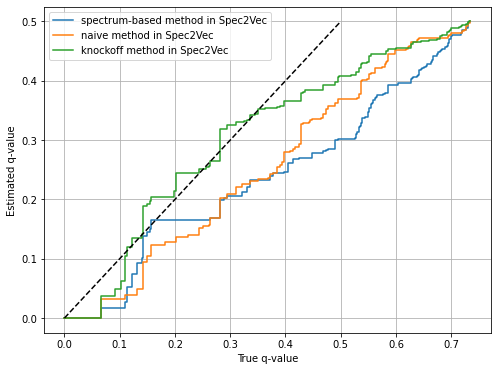

In [16]:
import plot_q_vals
plot_q_vals.plot_q_vals(q_list_true, {k:v for k,v in q_list_decoys.items() if 'Spec2Vec' in k} )

In [17]:
# Calculate cosine similarity for target-query match
from cosine_calc import get_hits
hits_cosine = get_hits(spectrums_query_cosine, spectrums_lib_cosine, 3, cosine_tol=0.005, passatutto=True)

In [18]:
from rdkit.Chem import MolFromSmiles, MolToSmiles, MolFromInchi
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula
def add_pmz(specs):
    for s in specs:
        s.set('precursor_mz', s.get('parent_mass', 0))

add_pmz(spectrums_query_cosine)

In [19]:
# Calculate cosine similarity for query-decoy match
from cosine_calc import get_hits
hits_decoys_cond_cosine = get_hits(spectrums_query_cosine, decoys_cond_cosine, 3, "precursor_mz", cosine_tol=0.005, decoys=True, passatutto=True)
hits_decoys_rand_cosine = get_hits(spectrums_query_cosine, decoys_rand_cosine, 3, "precursor_mz", cosine_tol=0.005, decoys=True, passatutto=True)

In [20]:
#lengths of all cosine hits
print(len(hits_cosine))
print(len(hits_decoys_cond_cosine))
print(len(hits_decoys_rand_cosine))

286
280
297


In [21]:
# Calculate true q-value scores for comparison with contemporary cosince
from q_value_calc import calculate_q_value
q_list_true_cosine = calculate_q_value(hits_cosine)

In [22]:
# Calculate estimated q-value scores (cosine comparison again)
q_list_decoys['spectrum-based method'] = calculate_q_value(hits_cosine+hits_decoys_cond_cosine,True)
q_list_decoys['naive method'] = calculate_q_value(hits_cosine+hits_decoys_rand_cosine,True)

Custom plotting to combine Spec2Vec and Cosine results

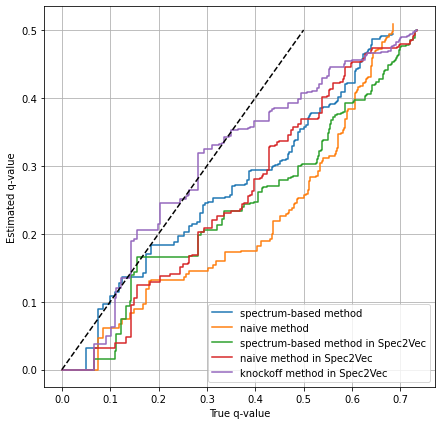

In [23]:
import pylab as plt

def combine_true_est(q_val_true, q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true) - 1 and q_val_true[q_idx + 1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res


to_plot = {}
for label, q_val_est in q_list_decoys.items():
    if 'Spec2Vec' in label:
        to_plot[label] = list(zip(*combine_true_est(q_list_true, q_val_est)))[1], list(zip(*combine_true_est(q_list_true, q_val_est)))[2]
    else:
        to_plot[label] = list(zip(*combine_true_est(q_list_true_cosine, q_val_est)))[1], list(zip(*combine_true_est(q_list_true_cosine, q_val_est)))[2]
        
fig, ax = plt.subplots(figsize=(7, 7))

# print CosineGreedy-based decoys first, to preserve colours from passatutto.ipynb
label = 'spectrum-based method'
tru,est = to_plot[label]
plt.plot(tru, est, label=label)
label = 'naive method'
tru,est = to_plot[label]
plt.plot(tru, est, label=label)

for label, (tru, est) in to_plot.items():
    if 'Spec2Vec' in label:
        plt.plot(tru, est, label=label)
plt.plot([0, 0.5], [0, 0.5], 'k--')
plt.xlabel('True q-value')
plt.ylabel('Estimated q-value')
plt.legend()
plt.grid()


In [24]:
# Error statistics
for label, (tru, est) in to_plot.items():
    vals = [ abs(e-t) for t,e in zip(tru,est) ]

    print("For", label)
    print("avg error:", sum(vals) / len(vals) )
    vals = [ abs(e-t) for t,e in zip(tru,est) if t<0.5 ]
    print("avg error for true q-value < 0.5:", sum(vals) / len(vals) )


For spectrum-based method in Spec2Vec
avg error: 0.1771987204302911
avg error for true q-value < 0.5: 0.0958066244246339
For naive method in Spec2Vec
avg error: 0.14759973848248314
avg error for true q-value < 0.5: 0.09038302322985135
For knockoff method in Spec2Vec
avg error: 0.11742089210216285
avg error for true q-value < 0.5: 0.03607749776898686
For spectrum-based method
avg error: 0.11494447341689511
avg error for true q-value < 0.5: 0.06203971489761826
For naive method
avg error: 0.17030920427164944
avg error for true q-value < 0.5: 0.11859910896014371
